In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import multiprocessing as mp
from tqdm import tqdm
import time

# For CNN
import torch
import torch.nn
import torch.optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax

### Reading images

In [2]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
with open("./val.txt") as f:
    val_file_list = f.readlines()
with open("./test.txt") as f:
    test_file_list = f.readlines()

train_file_list = [x.strip().split(sep=" ") for x in train_file_list]
val_file_list = [x.strip().split(sep=" ") for x in val_file_list]
test_file_list = [x.strip().split(sep=" ") for x in test_file_list]

train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

In [3]:
print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

# cpus:  64


In [4]:
def ReadImage(filePath):
    image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    # image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (256, 256))
    return image

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

100%|██████████| 450/450 [00:00<00:00, 169641.99it/s]


In [5]:
# resize the images to 256x256
def ResizeImage(image):
    # resized_img = cv2.resize(image, (256, 256))
    resized_img = cv2.resize(image, (64, 64))
    return resized_img

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))

100%|██████████| 450/450 [00:00<00:00, 715.89it/s]


### CNN

In [6]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
# prepare dataloader
BATCH_SIZE = 32
IMG_W, IMG_H = 64, 64

resized_train_imgs = np.array(resized_train_imgs)
resized_val_imgs = np.array(resized_val_imgs)
resized_test_imgs = np.array(resized_test_imgs)

resized_train_imgs = torch.FloatTensor(resized_train_imgs)
resized_val_imgs = torch.FloatTensor(resized_val_imgs)
resized_test_imgs = torch.FloatTensor(resized_test_imgs)
resized_train_imgs = resized_train_imgs.permute(0, 3, 1, 2)
resized_val_imgs = resized_val_imgs.permute(0, 3, 1, 2)
resized_test_imgs = resized_test_imgs.permute(0, 3, 1, 2)

train_label = torch.IntTensor(train_label)
val_label = torch.IntTensor(val_label)
test_label = torch.IntTensor(test_label)

train_dataset = TensorDataset(resized_train_imgs, train_label)
val_dataset = TensorDataset(resized_val_imgs, val_label)
test_dataset = TensorDataset(resized_test_imgs, test_label)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)

In [8]:
class CNN(torch.nn.Module):  # input_shape: (32, 3, 64, 64)
    def __init__(self, num_classes) -> None:
        super(CNN, self).__init__()
        # 1
        self.conv1 = torch.nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )  # (-1, 16, 62, 62)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )  # (16, 32, 32)
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=16)
        # 2
        self.conv2 = torch.nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )  # (32, 32, 32)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )  # (32, 16, 16)
        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=32)
        # 3
        self.conv3 = torch.nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
        )  # (64, 17, 17)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )  # (64, 8, 8)
        self.batchnorm3 = torch.nn.BatchNorm2d(num_features=64)
        # 4
        self.fc1 = torch.nn.Linear(
            in_features=64 * 8 * 8,
            out_features=128
        )
        self.relu4 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(
            in_features=128,
            out_features=num_classes
        )

    def forward(self, x):
        x = self.batchnorm1(self.pool1(self.relu1(self.conv1(x))))
        x = self.batchnorm2(self.pool2(self.relu2(self.conv2(x))))
        x = self.batchnorm3(self.pool3(self.relu3(self.conv3(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x


### Top-1 Accuracy

In [11]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [20]:
model = CNN(num_classes=50).to(device)
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

torch.manual_seed(42)
EPOCH = 30
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(EPOCH):
    # print(f"Epoch: {epoch + 1}")
    ### training
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader, start=1):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.argmax(softmax(y_logit, dim=1), dim=1) # top-1
        loss = loss_fcn(y_logit, y.to(torch.int64))
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if batch % 400 == 0:
            # print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    ### validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            val_logit = model(X)
            val_pred = torch.argmax(softmax(val_logit, dim=1), dim=1)

            val_loss += loss_fcn(val_logit, y.to(torch.int64))
            val_acc += accuracy_fn(y, val_pred)

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    print(f"Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Validation loss: {val_loss:.5f}, Validation acc: {val_acc:.2f}%")

Train loss: 3.73052, Train acc: 7.60% | Validation loss: 3.54263, Validation acc: 10.62%
Train loss: 3.34449, Train acc: 14.37% | Validation loss: 3.12171, Validation acc: 20.42%
Train loss: 3.09917, Train acc: 18.33% | Validation loss: 2.91419, Validation acc: 23.33%
Train loss: 2.96027, Train acc: 21.11% | Validation loss: 3.00306, Validation acc: 18.33%
Train loss: 2.85989, Train acc: 23.52% | Validation loss: 3.00853, Validation acc: 20.42%
Train loss: 2.77751, Train acc: 25.40% | Validation loss: 2.96552, Validation acc: 23.12%
Train loss: 2.70845, Train acc: 27.07% | Validation loss: 2.71663, Validation acc: 24.58%
Train loss: 2.64211, Train acc: 28.78% | Validation loss: 2.66943, Validation acc: 28.75%
Train loss: 2.58231, Train acc: 30.10% | Validation loss: 2.61652, Validation acc: 30.00%
Train loss: 2.52654, Train acc: 31.40% | Validation loss: 2.54123, Validation acc: 29.79%
Train loss: 2.47561, Train acc: 32.67% | Validation loss: 2.71605, Validation acc: 26.67%
Train loss:

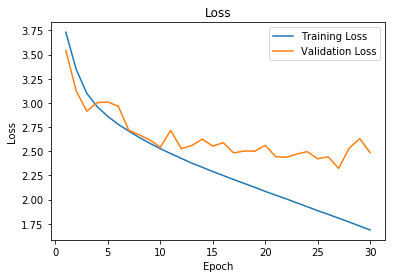

In [21]:
plt.plot(range(1, EPOCH+1), train_loss_list, label='Training Loss')
plt.plot(range(1, EPOCH+1), val_loss_list, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

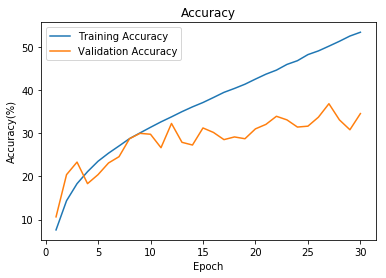

In [22]:
plt.plot(range(1, EPOCH+1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, EPOCH+1), val_acc_list, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.show()

### Top-5 Accuracy

In [23]:
def ComputeTop5Acc(y_logit, y):
    y_prob = softmax(y_logit, dim=1)
    y_pred_top5 = y_prob.argsort(axis=1)[:, -5:]
    y_true_in_top5 = [y[i] in y_pred_top5[i] for i in range(len(y))]
    
    return (sum(np.array(y_true_in_top5) == np.array([True]*len(y))) / len(y)) * 100

In [24]:
model = CNN(num_classes=50).to(device)
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

torch.manual_seed(42)
EPOCH = 30
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(EPOCH):
    # print(f"Epoch: {epoch + 1}")
    ### training
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader, start=1):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.argmax(softmax(y_logit, dim=1), dim=1) # top-1
        loss = loss_fcn(y_logit, y.to(torch.int64))
        train_loss += loss
        train_acc += ComputeTop5Acc(y_logit, y)  # top-5

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if batch % 400 == 0:
            # print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    ### validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            val_logit = model(X)
            val_pred = torch.argmax(softmax(val_logit, dim=1), dim=1)

            val_loss += loss_fcn(val_logit, y.to(torch.int64))
            val_acc += ComputeTop5Acc(val_logit, y)

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    print(f"Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Validation loss: {val_loss:.5f}, Validation acc: {val_acc:.2f}%")

Train loss: 3.72014, Train acc: 25.30% | Validation loss: 3.50362, Validation acc: 34.79%
Train loss: 3.34141, Train acc: 41.00% | Validation loss: 3.10914, Validation acc: 48.33%
Train loss: 3.08817, Train acc: 49.13% | Validation loss: 2.91942, Validation acc: 56.46%
Train loss: 2.94355, Train acc: 53.60% | Validation loss: 2.91179, Validation acc: 56.04%
Train loss: 2.84548, Train acc: 56.66% | Validation loss: 2.90498, Validation acc: 53.54%
Train loss: 2.76980, Train acc: 58.77% | Validation loss: 2.84877, Validation acc: 56.25%
Train loss: 2.70474, Train acc: 60.57% | Validation loss: 2.71204, Validation acc: 60.83%
Train loss: 2.64504, Train acc: 62.27% | Validation loss: 2.63148, Validation acc: 64.79%
Train loss: 2.58801, Train acc: 63.70% | Validation loss: 2.73068, Validation acc: 58.54%
Train loss: 2.53547, Train acc: 65.39% | Validation loss: 2.59944, Validation acc: 62.08%
Train loss: 2.48390, Train acc: 66.60% | Validation loss: 2.71676, Validation acc: 58.54%
Train loss

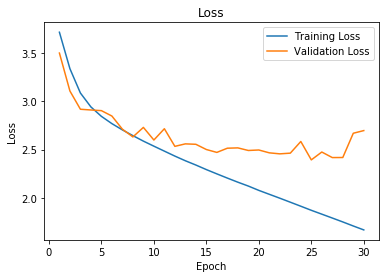

In [25]:
plt.plot(range(1, EPOCH+1), train_loss_list, label='Training Loss')
plt.plot(range(1, EPOCH+1), val_loss_list, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

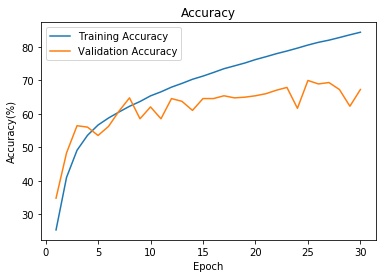

In [26]:
plt.plot(range(1, EPOCH+1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, EPOCH+1), val_acc_list, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.show()